<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210928_DictL_featureselection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import math
import statistics
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import DictionaryLearning
from xgboost import XGBRegressor

import warnings
warnings.simplefilter('ignore')

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['notebook',
 'data',
 'C0002_21_09_2021.csv',
 'C0002_23_09_2021.csv',
 'ref',
 'C0002_27_09_2021.csv',
 'C0002_27_09_2021_2.csv',
 'C0002_27_09_2021_3.csv']

In [18]:
#データの読み込み
dataframe_train = pd.read_csv(
    os.path.join(DIR, 'data', 'Train_Unit_20210903', 'dataset_train_all.csv'),
    encoding='utf-8')
dataframe_test = pd.read_csv(
    os.path.join(DIR, 'data', 'Test_Unit_20210903', 'dataset_test_all.csv'),
    encoding='utf-8')

関数群

In [19]:
def data_processed(dataframe):
  #不必要なIndex列と空白列を削除。
  df = dataframe.drop(dataframe.columns[[0, 7]], axis=1)

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
            'Voltage Measured (V)' : 'VM',
            'Voltage Charge (V)' : 'VC',
            'Current Measured (Amps)' : 'CM', 
            'Current Charge (Amps)' : 'CC',
            'Temperature (degree C)': 'Temp', 
            'unit' : 'unit_name', 
            'charge_mode' : 'mode', 
            'Cycle_num' : 'Cycle',
            'Voltage Load (V)' : 'VL',
            'Current Load (Amps)' : 'CL'
  }
  
  df = df.rename(columns=col_list)
  
  #ユニットとサイクルでソート。
  df = df.sort_values(['unit_name', 'Cycle']).reset_index(drop=True)

  return df

In [20]:
#関数化：グループIDを付与する。
def add_group(max_value, df, interval):
  group_list = []
  for i in np.arange(1, max_value/interval):
      lower = interval*i-interval
      upper = interval*i
      tmp_df = df[ (lower < df['Time']) & (upper > df['Time'])]
      tmp_df['group_id'] = f'{lower} -- {upper}'
      group_list.append(tmp_df)
  df_add_group = pd.concat(group_list)
  return df_add_group

In [21]:
#max_value = 11000
#base_df = train_c
#interval = 50
#col = 'VM'
#mode = C

#DictLによる特徴量の抽出とデータフレーム化
def autofe_by_dictl(max_value, base_df, interval, col, mode):

  add_group_id = add_group(max_value, base_df, interval=interval)
  add_group_id = add_group_id.reset_index(drop=True)

  #サイクル、グループID毎にグループ化し、平均値をとる。
  grouped_df_mean = add_group_id.groupby(['Cycle', 'group_id']).mean().sort_values(['Cycle','Time'])

  #ピボットテーブルを作成
  pt = pd.pivot_table(grouped_df_mean, index='group_id', columns='Cycle', values=col)
  #欠測値は削除。
  pt = pt.dropna()

  #学習データの設定
  X = np.asarray(pt.values)
  X_train = X

  #辞書学習による特徴量抽出
  n_components = 10
  dict_learner = DictionaryLearning(
        n_components=n_components,
        fit_algorithm='cd',
        transform_algorithm = 'lasso_lars',
        random_state = 42,
        positive_code = False,
        positive_dict = False,
        alpha = 1
    )

  X_train_transformed = dict_learner.fit_transform(X_train)

  cols = []
  for i in np.arange(0, n_components):
    c = f'Component_{i}_{col}_{mode}'
    cols.append(c)
  
  df_dict = pd.DataFrame(dict_learner.components_.T, columns=cols)

  return df_dict

In [22]:
def make_dataset(df_charge, df_discharge):

  col_charge = df_charge.columns[1:6]

  df_dict_charge = []
  for col in col_charge:
    tmp_df_charge = autofe_by_dictl(11000, df_charge, 50, col, 'C')
    df_dict_charge.append(tmp_df_charge)

  col_discharge = list([df_discharge.columns[1], df_discharge.columns[3], df_discharge.columns[5], df_discharge.columns[-2]])

  df_dict_discharge = []
  for col in col_discharge:
    tmp_df_discharge = autofe_by_dictl(11000, df_discharge, 50, col, 'D')
    df_dict_discharge.append(tmp_df_discharge)

  df_merge_charge = pd.concat([df_dict_charge[0],df_dict_charge[1], df_dict_charge[2], df_dict_charge[3],df_dict_charge[4]],axis=1)
  df_merge_discharge = pd.concat([df_dict_discharge[0],df_dict_discharge[1], df_dict_discharge[2], df_dict_discharge[3]],axis=1)
  df_dict_merge = pd.concat([df_merge_charge, df_merge_discharge], axis=1)

  return df_dict_merge

In [23]:
df_train_base = data_processed(dataframe_train)
df_test_base = data_processed(dataframe_test)

In [24]:
df_train_base.head()

,Time,VM,VC,CM,CC,Temp,unit_name,mode,Cycle,VL,CL
0,0.000,3.3251,0.003,0.000302,-0.002,29.342,Train_Unit_1,Charge,1,NaN,NaN
1,2.516,3.0020,1.414,-3.362000,-3.370,29.336,Train_Unit_1,Charge,1,NaN,NaN
2,5.500,3.4346,4.142,1.508700,1.498,29.335,Train_Unit_1,Charge,1,NaN,NaN
3,8.391,3.4549,4.180,1.510000,1.498,29.342,Train_Unit_1,Charge,1,NaN,NaN
4,11.266,3.4688,4.196,1.508700,1.498,29.331,Train_Unit_1,Charge,1,NaN,NaN


生波形データ加工のポイント  
①充電のunit_1は、外れ値処理が必要(該当サイクルの削除)  
②放電のunit_3は、外れ値処理が必要(該当サイクルの削除)  
③放電のCMは、対象の特徴量から外す。  

In [25]:
#ユニット毎にデータ分け
df_unit_1 = df_train_base[df_train_base['unit_name'] == 'Train_Unit_1'].reset_index(drop=True)
df_unit_2 = df_train_base[df_train_base['unit_name'] == 'Train_Unit_2'].reset_index(drop=True)
df_unit_3 = df_train_base[df_train_base['unit_name'] == 'Train_Unit_3'].reset_index(drop=True)

In [26]:
#unit1の充電については、32サイクル目を除去。
df_unit_1 = df_unit_1[df_unit_1['Cycle'] !=32]

In [27]:
#unit3については、1サイクル目、39サイクル目を除去。
df_unit_3 = df_unit_3[(df_unit_3['Cycle'] !=1) & (df_unit_3['Cycle'] !=39)]

In [29]:
col_charge = list(df_train_base.columns[1:6])
col_charge

['VM', 'VC', 'CM', 'CC', 'Temp']

In [30]:
col_discharge = list([df_train_base.columns[1], df_train_base.columns[3], df_train_base.columns[5], df_train_base.columns[-2]])
col_discharge

['VM', 'CM', 'Temp', 'VL']

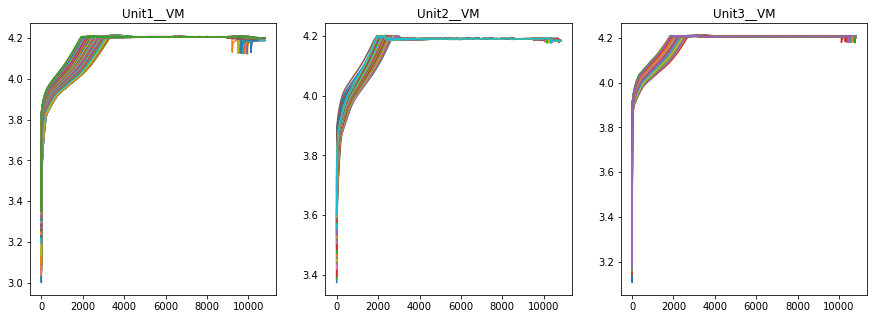

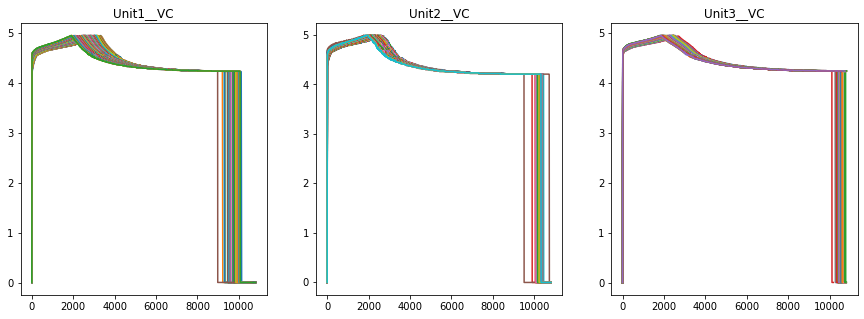

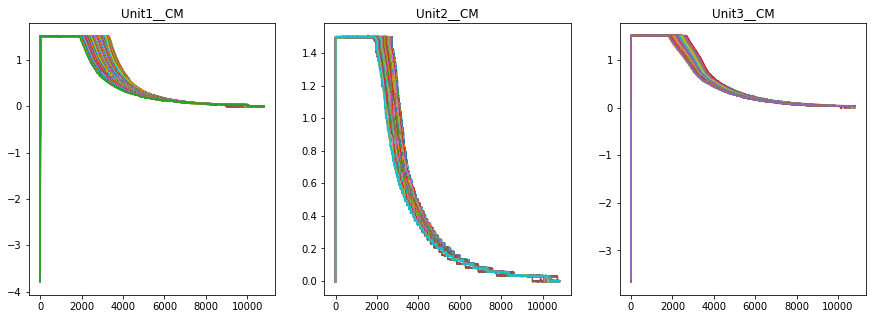

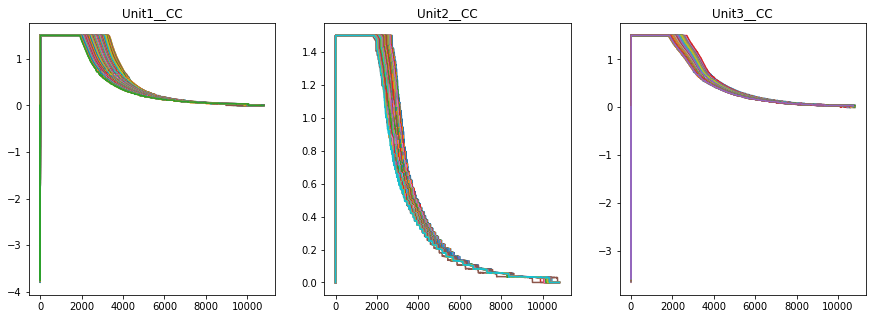

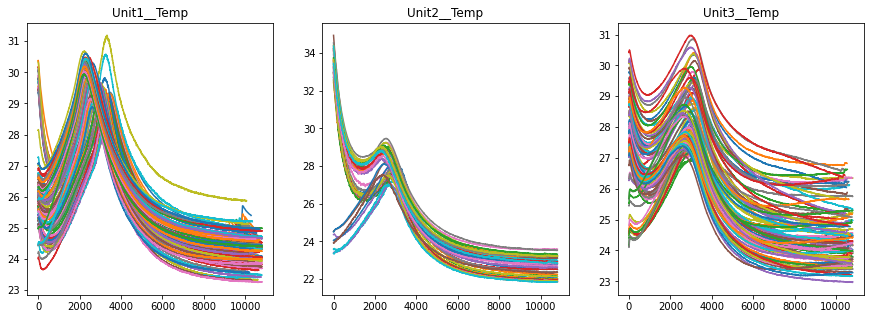

In [31]:
#プロット(充電)
mode = 'Charge'

cycles_1 = df_unit_1['Cycle'].unique()
cycles_2 = df_unit_2['Cycle'].unique()
cycles_3 = df_unit_3['Cycle'].unique()

for feature in col_charge:

  fig = plt.figure()
  fig.set_figwidth(15)
  fig.set_figheight(5)

  ax1 = fig.add_subplot(1, 3, 1)#ユニット1用
  ax2 = fig.add_subplot(1, 3, 2)#ユニット2用
  ax3 = fig.add_subplot(1, 3, 3)#ユニット3用

  for cycle in cycles_1:
    df_plot_1 = df_unit_1
    plot_x_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)]['Time']
    plot_y_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)][feature]
    ax1.plot(plot_x_1, plot_y_1)
    ax1.set_title(f'Unit1__{feature}')
    #ax.set_xticks(np.arange(0, cutoff_time, 1000))
    #ax.set_ylim(3, 5)

  for cycle in cycles_2:
    df_plot_2 = df_unit_2
    plot_x_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)]['Time']
    plot_y_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)][feature]
    ax2.plot(plot_x_2, plot_y_2)
    ax2.set_title(f'Unit2__{feature}')

  for cycle in cycles_3:
    df_plot_3 = df_unit_3
    plot_x_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)]['Time']
    plot_y_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)][feature]
    ax3.plot(plot_x_3, plot_y_3, label= f'Unit3__{feature}__{cycle}Cycle')
    ax3.set_title(f'Unit3__{feature}')

  #plt.legend()
  plt.show()


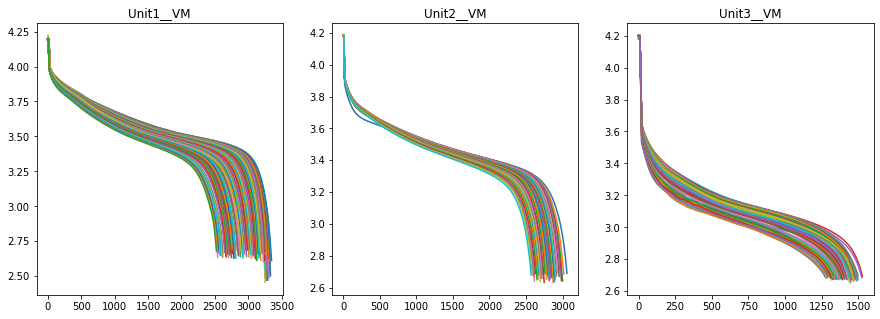

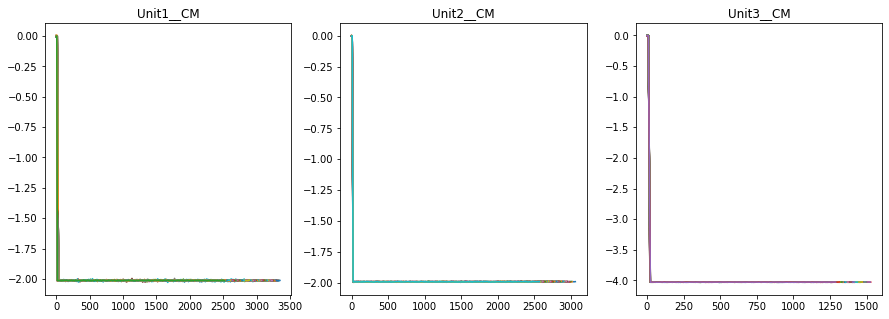

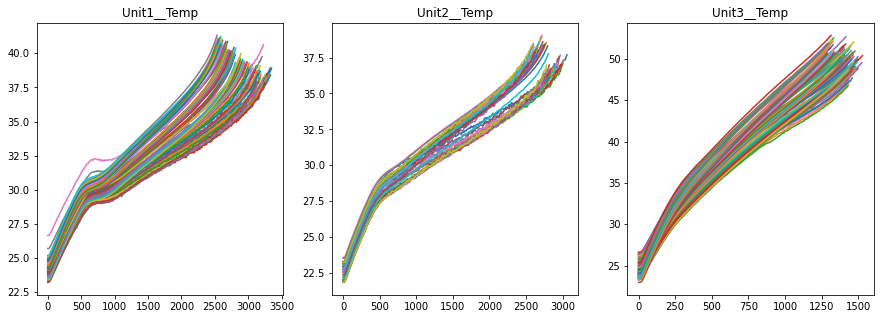

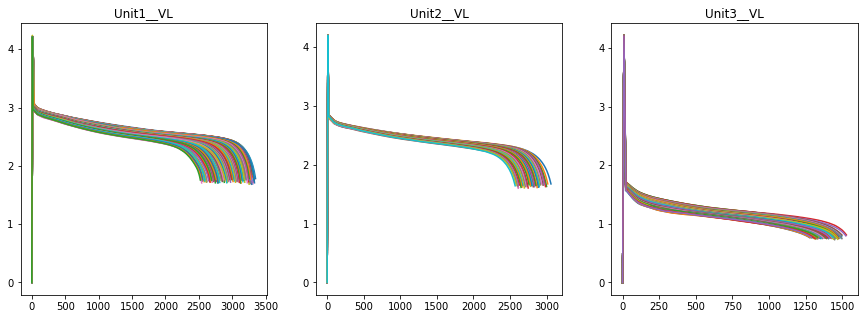

In [32]:
#プロット(放電)
mode = 'Discharge'

cycles_1 = df_unit_1['Cycle'].unique()
cycles_2 = df_unit_2['Cycle'].unique()
cycles_3 = df_unit_3['Cycle'].unique()

for feature in col_discharge:

  fig = plt.figure()
  fig.set_figwidth(15)
  fig.set_figheight(5)

  ax1 = fig.add_subplot(1, 3, 1)#ユニット1用
  ax2 = fig.add_subplot(1, 3, 2)#ユニット2用
  ax3 = fig.add_subplot(1, 3, 3)#ユニット3用

  for cycle in cycles_1:
    df_plot_1 = df_unit_1
    plot_x_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)]['Time']
    plot_y_1 = df_plot_1[ (df_plot_1['Cycle'] == cycle) & (df_plot_1['mode'] == mode)][feature]
    ax1.plot(plot_x_1, plot_y_1)
    ax1.set_title(f'Unit1__{feature}')
    #ax.set_xticks(np.arange(0, cutoff_time, 1000))
    #ax.set_ylim(3, 5)

  for cycle in cycles_2:
    df_plot_2 = df_unit_2
    plot_x_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)]['Time']
    plot_y_2 = df_plot_2[ (df_plot_2['Cycle'] == cycle) & (df_plot_2['mode'] == mode)][feature]
    ax2.plot(plot_x_2, plot_y_2)
    ax2.set_title(f'Unit2__{feature}')

  for cycle in cycles_3:
    df_plot_3 = df_unit_3
    plot_x_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)]['Time']
    plot_y_3 = df_plot_3[ (df_plot_3['Cycle'] == cycle) & (df_plot_3['mode'] == mode)][feature]
    ax3.plot(plot_x_3, plot_y_3, label= f'Unit3__{feature}__{cycle}Cycle')
    ax3.set_title(f'Unit3__{feature}')

  #plt.legend()
  plt.show()

# 単ユニット毎

学習データ・テストデータ作成

In [33]:
#充電と放電について、データセットを分ける(学習データ)
train_c_1 = df_unit_1[df_unit_1['mode'] == 'Charge']
train_c_2 = df_unit_2[df_unit_2['mode'] == 'Charge']
train_c_3 = df_unit_3[df_unit_3['mode'] == 'Charge']
train_d_1 = df_unit_1[df_unit_1['mode'] == 'Discharge']
train_d_2 = df_unit_2[df_unit_2['mode'] == 'Discharge']
train_d_3 = df_unit_3[df_unit_3['mode'] == 'Discharge']

In [35]:
#充電と放電について、データセットを分ける(テストデータ)
test_c_1 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_1')]
test_c_2 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_2')]
test_c_3 = df_test_base[(df_test_base['mode'] == 'Charge')&(df_test_base['unit_name'] == 'Test_Unit_3')]
test_d_1 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_1')]
test_d_2 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_2')]
test_d_3 = df_test_base[(df_test_base['mode'] == 'Discharge')&(df_test_base['unit_name'] == 'Test_Unit_3')]

In [36]:
df_train_dict_merge_unit_1 = make_dataset(train_c_1, train_d_1)
df_train_dict_merge_unit_2 = make_dataset(train_c_2, train_d_2)
df_train_dict_merge_unit_3 = make_dataset(train_c_3, train_d_3)

In [37]:
df_test_dict_merge_unit_1 = make_dataset(test_c_1, test_d_1)
df_test_dict_merge_unit_2 = make_dataset(test_c_2, test_d_2)
df_test_dict_merge_unit_3 = make_dataset(test_c_3, test_d_3)

In [38]:
#学習データにサイクルと目的変数(RUL)を付与する。
def add_rul(dict_dataframe):
  dict_dataframe['Cycle'] = dict_dataframe.index + 1
  dict_dataframe['RUL'] = dict_dataframe.shape[0] - dict_dataframe['Cycle']
  return dict_dataframe

In [39]:
df_train_unit_1 = add_rul(df_train_dict_merge_unit_1)
df_train_unit_2 = add_rul(df_train_dict_merge_unit_2)
df_train_unit_3 = add_rul(df_train_dict_merge_unit_3)

In [40]:
df_train_unit_1.head()

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C,Component_0_VC_C,Component_1_VC_C,Component_2_VC_C,Component_3_VC_C,Component_4_VC_C,Component_5_VC_C,Component_6_VC_C,Component_7_VC_C,Component_8_VC_C,Component_9_VC_C,Component_0_CM_C,Component_1_CM_C,Component_2_CM_C,Component_3_CM_C,Component_4_CM_C,Component_5_CM_C,Component_6_CM_C,Component_7_CM_C,Component_8_CM_C,Component_9_CM_C,Component_0_CC_C,Component_1_CC_C,Component_2_CC_C,Component_3_CC_C,Component_4_CC_C,Component_5_CC_C,Component_6_CC_C,Component_7_CC_C,Component_8_CC_C,Component_9_CC_C,...,Component_2_VM_D,Component_3_VM_D,Component_4_VM_D,Component_5_VM_D,Component_6_VM_D,Component_7_VM_D,Component_8_VM_D,Component_9_VM_D,Component_0_CM_D,Component_1_CM_D,Component_2_CM_D,Component_3_CM_D,Component_4_CM_D,Component_5_CM_D,Component_6_CM_D,Component_7_CM_D,Component_8_CM_D,Component_9_CM_D,Component_0_Temp_D,Component_1_Temp_D,Component_2_Temp_D,Component_3_Temp_D,Component_4_Temp_D,Component_5_Temp_D,Component_6_Temp_D,Component_7_Temp_D,Component_8_Temp_D,Component_9_Temp_D,Component_0_VL_D,Component_1_VL_D,Component_2_VL_D,Component_3_VL_D,Component_4_VL_D,Component_5_VL_D,Component_6_VL_D,Component_7_VL_D,Component_8_VL_D,Component_9_VL_D,Cycle,RUL
0,-0.090137,-0.082573,0.013565,0.068276,0.042374,-0.020932,0.058266,-0.132824,-0.030857,0.039517,-0.089149,0.103792,-0.09245,-0.090546,-0.097499,0.098757,-0.093523,-0.090908,-0.090501,-0.092172,-0.090275,0.126494,0.100338,-0.074660,0.153474,0.023828,-0.003346,0.015089,-0.129184,0.008475,-0.090283,0.126524,0.100396,0.007900,0.102103,-0.114228,0.084304,0.103579,0.034146,-0.068638,...,0.013565,0.068276,0.042374,-0.020932,0.058266,-0.132824,-0.030857,0.039517,0.090176,-0.061293,-0.018371,0.027996,-0.042920,0.004977,0.006399,0.120538,0.013680,-0.031043,-0.089476,-0.089845,0.068480,0.103351,-0.020653,0.093077,-0.129122,0.195629,-0.009391,0.049131,-0.092537,0.097131,0.099438,-0.028260,0.008510,0.049915,-0.012504,0.083745,0.014606,0.064436,1,122
1,-0.090131,-0.082559,0.032219,-0.093802,0.066211,0.016977,0.055526,-0.151035,0.005861,0.020304,-0.089172,0.103792,-0.09245,-0.090545,-0.097500,0.098757,-0.093523,-0.090908,-0.090722,-0.092172,-0.090272,0.126122,0.100408,0.093788,-0.143312,-0.089697,-0.044672,0.094746,-0.067875,0.108455,-0.090273,0.126128,0.100416,0.063793,-0.063987,0.047421,-0.014395,-0.066230,-0.106674,0.071377,...,0.032219,-0.093802,0.066211,0.016977,0.055526,-0.151035,0.005861,0.020304,0.090171,-0.061342,0.106865,0.057973,0.024278,0.000706,0.062567,0.108017,0.002257,-0.144319,-0.089828,-0.093882,0.069515,0.107973,-0.142918,-0.058878,-0.051909,0.101449,0.000577,0.097167,-0.092245,0.097059,0.099359,-0.111345,0.069442,0.072542,-0.109654,0.150819,-0.088250,-0.045880,2,121
2,-0.090128,-0.082783,0.050726,-0.007090,0.054925,0.079036,0.011369,-0.039609,0.142178,0.051228,-0.089207,0.103792,-0.09245,-0.090545,-0.097291,0.098757,-0.093523,-0.090908,-0.091065,-0.092172,-0.090267,0.124758,0.100576,0.031466,0.001453,0.009206,-0.027408,0.025087,-0.112868,0.140099,-0.090256,0.124806,0.100568,0.062956,0.101876,-0.083224,0.113201,-0.035272,-0.050488,-0.030215,...,0.050726,-0.007090,0.054925,0.079036,0.011369,-0.039609,0.142178,0.051228,0.090164,-0.061394,0.055946,-0.106108,-0.039877,-0.066021,0.040627,-0.061638,-0.033181,-0.078303,-0.089642,-0.094824,0.069681,0.109119,0.041317,0.015555,0.055471,-0.032061,-0.067717,0.010207,-0.092155,0.096908,0.099339,0.066794,0.094804,0.055122,0.108890,-0.154023,-0.055903,0.078750,3,120
3,-0.090128,-0.082607,-0.120536,0.059407,0.042070,-0.022907,-0.062253,-0.025241,-0.078754,-0.030705,-0.089204,0.103792,-0.09245,-0.090544,-0.097354,0.098757,-0.093523,-0.090908,-0.091104,-0.092172,-0.090259,0.124937,0.100469,-0.054937,-0.027738,-0.096716,0.088987,0.057458,-0.062537,0.027712,-0.090250,0.124951,0.100521,0.051665,0.177156,-0.101064,-0.035912,0.001491,-0.123223,-0.018820,...,-0

特徴量の選択

In [112]:
#ユニット1
df_col_1 = df_train_unit_1.corr()
cont_rate_1 = df_col_1['Cycle']**2
cont_rate_1_select = cont_rate_1[cont_rate_1 > 0.8].iloc[:-2,]
selected_columns_1 = list(cont_rate_1_select.index)
selected_columns_1

['Component_0_VM_C',
 'Component_1_VM_C',
 'Component_0_VC_C',
 'Component_4_VC_C',
 'Component_1_CM_C',
 'Component_1_CC_C',
 'Component_1_Temp_C',
 'Component_0_VM_D',
 'Component_1_VM_D',
 'Component_2_Temp_D',
 'Component_0_VL_D',
 'Component_1_VL_D']

In [122]:
#ユニット2
df_corr_2 = df_train_unit_2.corr()
cont_rate_2 = df_corr_2['Cycle']**2
cont_rate_2_select = cont_rate_2[cont_rate_2 > 0.8].iloc[:-2,]
selected_columns_2 = list(cont_rate_2_select.index)
selected_columns_2

['Component_1_CM_C',
 'Component_1_CC_C',
 'Component_1_VM_D',
 'Component_1_Temp_D',
 'Component_0_VL_D',
 'Component_1_VL_D']

In [123]:
#ユニット3
df_corr_3 = df_train_unit_3.corr()
cont_rate_3 = df_corr_3['Cycle']**2
cont_rate_3_select = cont_rate_3[cont_rate_3 > 0.8].iloc[:-2,]
selected_columns_3 = list(cont_rate_3_select.index)
selected_columns_3

['Component_0_VC_C',
 'Component_1_VC_C',
 'Component_1_CM_C',
 'Component_1_CC_C',
 'Component_1_Temp_D',
 'Component_0_VL_D']

学習～推論

In [125]:
train_X_1 = df_train_unit_1.loc[:, selected_columns_1]
train_X_2 = df_train_unit_2.loc[:, selected_columns_2]
train_X_3 = df_train_unit_3.loc[:, selected_columns_3]

train_y_1 = df_train_unit_1.iloc[:,-1]
train_y_2 = df_train_unit_2.iloc[:,-1]
train_y_3 = df_train_unit_3.iloc[:,-1]

In [139]:
#train_X_2
#train_y_1

In [127]:
test_X_1 = df_test_dict_merge_unit_1.loc[:, selected_columns_1]
test_X_2 = df_test_dict_merge_unit_2.loc[:, selected_columns_2]
test_X_3 = df_test_dict_merge_unit_3.loc[:, selected_columns_3]

In [128]:
print('-'*5)
print('カラム数の確認')
print(f'学習D_1のカラム数：{train_X_1.shape[1]}',f'テストD_1のカラム数：{test_X_1.shape[1]}')
print(f'学習D_2のカラム数：{train_X_2.shape[1]}',f'テストD_1のカラム数：{test_X_2.shape[1]}')
print(f'学習D_3のカラム数：{train_X_3.shape[1]}',f'テストD_1のカラム数：{test_X_3.shape[1]}')

print('-'*5)
print('レコード数の確認')
print(f'学習D_1のレコード数：{train_X_1.shape[0]}',f'テストD_1のレコード数：{test_X_1.shape[0]}')
print(f'学習D_2のレコード数：{train_X_2.shape[0]}',f'テストD_1のレコード数：{test_X_2.shape[0]}')
print(f'学習D_3のレコード数：{train_X_3.shape[0]}',f'テストD_1のレコード数：{test_X_3.shape[0]}')

-----
カラム数の確認
学習D_1のカラム数：12 テストD_1のカラム数：12
学習D_2のカラム数：6 テストD_1のカラム数：6
学習D_3のカラム数：6 テストD_1のカラム数：6
-----
レコード数の確認
学習D_1のレコード数：123 テストD_1のレコード数：70
学習D_2のレコード数：40 テストD_1のレコード数：12
学習D_3のレコード数：95 テストD_1のレコード数：55


In [129]:
#モデルの作成
model_1 = XGBRegressor(n_estimators=20, random_state=71)
model_2 = XGBRegressor(n_estimators=20, random_state=71)
model_3 = XGBRegressor(n_estimators=20, random_state=71)

model_1.fit(train_X_1,train_y_1)
model_2.fit(train_X_2,train_y_2)
model_3.fit(train_X_3,train_y_3)

[14:15:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:15:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=71,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [130]:
#テストデータの予測値を出力
pred_1 = model_1.predict(test_X_1)
pred_2 = model_2.predict(test_X_2)
pred_3 = model_3.predict(test_X_3)

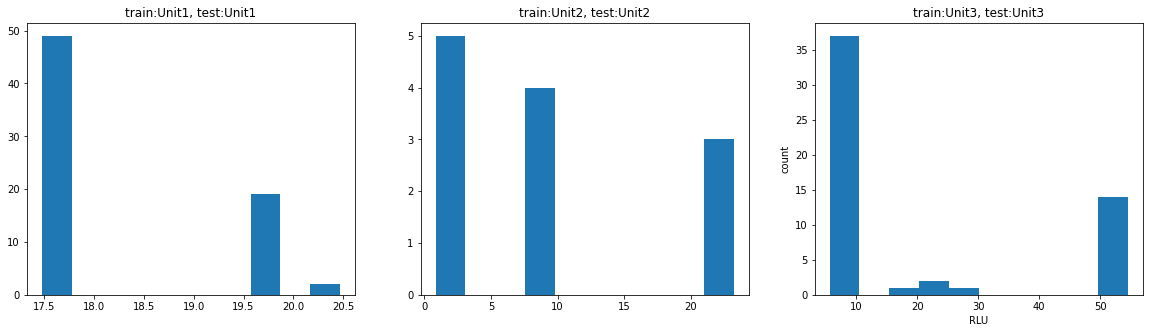

In [131]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.hist(pred_1, bins=10)
ax1.set_title('train:Unit1, test:Unit1')

ax2.hist(pred_2, bins=10)
ax2.set_title('train:Unit2, test:Unit2')

ax3.hist(pred_3, bins=10)
ax3.set_title('train:Unit3, test:Unit3')

plt.xlabel('RLU')
plt.ylabel('count')
plt.show()

In [132]:
#ヒストグラムの平均値をRULと定義
RUL_unit_1 = round(statistics.mean(pred_1))
RUL_unit_2 = round(statistics.mean(pred_2))
RUL_unit_3 = round(statistics.mean(pred_3))

print('RUL_test_unit_1：',RUL_unit_1)
print('RUL_test_unit_2：',RUL_unit_2)
print('RUL_test_unit_3：',RUL_unit_3)

RUL_test_unit_1： 18
RUL_test_unit_2： 9
RUL_test_unit_3： 19


#全ユニット

In [133]:
#充電と放電について、データセットを分ける(学習データ)
train_c = pd.concat([train_c_1, train_c_2, train_c_3], axis=0)#縦に連結
train_d = pd.concat([train_d_1, train_d_2, train_d_3], axis=0)#縦に連結

In [137]:
df_train_dict_merge = make_dataset(train_c, train_d)

In [138]:
df_train = add_rul(df_train_dict_merge)

In [140]:
df_train.head()

,Component_0_VM_C,Component_1_VM_C,Component_2_VM_C,Component_3_VM_C,Component_4_VM_C,Component_5_VM_C,Component_6_VM_C,Component_7_VM_C,Component_8_VM_C,Component_9_VM_C,Component_0_VC_C,Component_1_VC_C,Component_2_VC_C,Component_3_VC_C,Component_4_VC_C,Component_5_VC_C,Component_6_VC_C,Component_7_VC_C,Component_8_VC_C,Component_9_VC_C,Component_0_CM_C,Component_1_CM_C,Component_2_CM_C,Component_3_CM_C,Component_4_CM_C,Component_5_CM_C,Component_6_CM_C,Component_7_CM_C,Component_8_CM_C,Component_9_CM_C,Component_0_CC_C,Component_1_CC_C,Component_2_CC_C,Component_3_CC_C,Component_4_CC_C,Component_5_CC_C,Component_6_CC_C,Component_7_CC_C,Component_8_CC_C,Component_9_CC_C,...,Component_2_VM_D,Component_3_VM_D,Component_4_VM_D,Component_5_VM_D,Component_6_VM_D,Component_7_VM_D,Component_8_VM_D,Component_9_VM_D,Component_0_CM_D,Component_1_CM_D,Component_2_CM_D,Component_3_CM_D,Component_4_CM_D,Component_5_CM_D,Component_6_CM_D,Component_7_CM_D,Component_8_CM_D,Component_9_CM_D,Component_0_Temp_D,Component_1_Temp_D,Component_2_Temp_D,Component_3_Temp_D,Component_4_Temp_D,Component_5_Temp_D,Component_6_Temp_D,Component_7_Temp_D,Component_8_Temp_D,Component_9_Temp_D,Component_0_VL_D,Component_1_VL_D,Component_2_VL_D,Component_3_VL_D,Component_4_VL_D,Component_5_VL_D,Component_6_VL_D,Component_7_VL_D,Component_8_VL_D,Component_9_VL_D,Cycle,RUL
0,-0.089324,-0.181244,-0.036062,-0.050758,-0.059486,-0.070201,-0.093438,0.112768,-0.062904,0.023883,-0.089152,0.110195,-0.091026,0.122200,0.089672,0.099852,0.095311,-0.115233,-0.106709,0.095420,-0.089536,0.111819,-0.100239,0.119386,-0.076254,0.068358,0.078989,0.168396,0.010097,-0.025904,-0.090036,0.112497,-0.100923,0.119386,-0.076254,0.068358,0.078989,0.168396,0.010097,-0.025904,...,-0.092947,-0.026482,-0.002566,-0.071721,-0.022561,0.054619,-0.104856,-0.078625,0.066795,-0.089376,0.075836,0.083674,-0.068405,0.071417,0.081357,0.166722,0.006425,-0.284748,-0.088284,-0.077627,0.075554,-0.079677,0.069466,-0.076012,-0.077290,0.092990,0.063465,-0.062936,-0.089032,0.045638,-0.100784,-0.092337,0.107049,-0.025539,0.014991,-0.123744,-0.068117,-0.052658,1,123
1,-0.089603,0.082116,0.014003,0.144046,-0.017581,-0.045885,0.018651,-0.075522,0.076133,-0.083149,-0.089641,0.110560,-0.091327,0.122552,0.090007,0.100186,0.095633,-0.115582,-0.107080,0.094042,-0.089650,0.107556,-0.101050,-0.058501,-0.053280,0.027689,0.045771,0.072976,-0.030548,0.022389,-0.089924,0.107898,-0.101431,-0.058501,-0.053280,0.027689,0.045771,0.072976,-0.030548,0.022389,...,-0.084096,0.117668,-0.009323,0.028246,-0.055958,0.066295,0.023217,0.016425,0.092708,-0.089285,0.105142,0.115828,-0.097363,0.097962,-0.068206,-0.041264,-0.043107,-0.048151,-0.088305,-0.070912,0.104704,-0.136582,0.097685,-0.092667,-0.094148,0.091658,0.093070,-0.100547,-0.089517,-0.247352,-0.071902,-0.090550,0.083128,-0.152960,0.071699,0.039294,0.107967,0.113073,2,122
2,-0.089612,-0.111424,-0.173459,0.166928,-0.057619,0.116378,0.103003,0.048498,0.146782,-0.071279,-0.089625,0.110485,-0.091335,0.115357,0.090001,0.100187,0.095639,-0.115578,-0.107065,0.093681,-0.089674,0.105537,-0.100384,0.008406,0.019129,-0.156942,0.158340,-0.113149,-0.106105,-0.168390,-0.089937,0.105866,-0.100747,0.008406,0.019129,-0.156942,0.158340,-0.113149,-0.106105,-0.168390,...,-0.084702,-0.004728,-0.013884,0.013364,-0.015683,0.008074,-0.072198,0.070815,0.093025,-0.089341,0.103251,0.102376,-0.096318,0.100543,0.013412,-0.200157,0.028946,0.086010,-0.087801,-0.071116,0.101059,-0.107805,0.096113,-0.095449,-0.089491,0.091170,0.091780,-0.095211,-0.088907,0.140780,-0.073708,-0.091883,0.083625,-0.136029,-0.255212,-0.115993,-0.080185,0.035647,3,121
3,-0.089624,0.067228,0.039907,-0.064229,-0.210142,0.159317,-0.043401,0.017830,0.095270,0.105180,-0.089652,0.104074,-0.091342,0.053686,0.089980,0.100240,0.095619,-0.099566,-0.106900,0.093374,-0.089671,0.104102,-0.099810,-0.012252,-0.271217,0.079165,0.171138,-0.028741,0.119803,0.073724,-0.089945,0.104452,-0.100196,-0.012252,-0.271217,0.079165,0.171138,-0.028741,0.119803,0.

In [146]:
#特徴量の選択
df_corr = df_train.corr()
cont_rate = df_corr['Cycle']**2
cont_rate_select = cont_rate[cont_rate > 0.6].iloc[:-2,]
selected_columns = list(cont_rate_select.index)
selected_columns

['Component_0_VM_C',
 'Component_9_VC_C',
 'Component_1_CM_C',
 'Component_2_CM_C',
 'Component_1_CC_C',
 'Component_2_CC_C',
 'Component_2_Temp_C',
 'Component_2_VM_D',
 'Component_0_Temp_D',
 'Component_1_Temp_D',
 'Component_2_VL_D']

In [147]:
train_X = df_train.loc[:, selected_columns]
train_y = df_train.iloc[:,-1]

In [148]:
test_X_1 = df_test_dict_merge_unit_1.loc[:, selected_columns]
test_X_2 = df_test_dict_merge_unit_2.loc[:, selected_columns]
test_X_3 = df_test_dict_merge_unit_3.loc[:, selected_columns]

In [149]:
#モデルの作成
model = XGBRegressor(n_estimators=20, random_state=71)
model.fit(train_X,train_y)

[14:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=71,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [150]:
#テストデータの予測値を出力
pred_1 = model.predict(test_X_1)
pred_2 = model.predict(test_X_2)
pred_3 = model.predict(test_X_3)

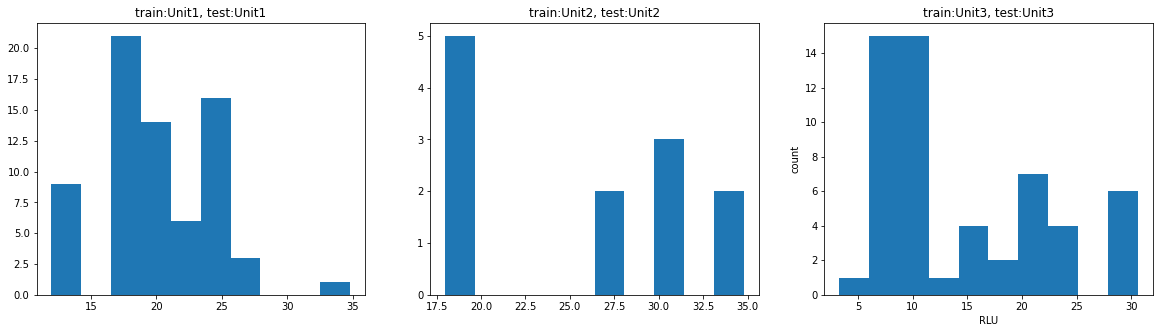

In [151]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.hist(pred_1, bins=10)
ax1.set_title('train:Unit1, test:Unit1')

ax2.hist(pred_2, bins=10)
ax2.set_title('train:Unit2, test:Unit2')

ax3.hist(pred_3, bins=10)
ax3.set_title('train:Unit3, test:Unit3')

plt.xlabel('RLU')
plt.ylabel('count')
plt.show()

In [152]:
#ヒストグラムの平均値をRULと定義
RUL_unit_1 = round(statistics.mean(pred_1))
RUL_unit_2 = round(statistics.mean(pred_2))
RUL_unit_3 = round(statistics.mean(pred_3))

print('RUL_test_unit_1：',RUL_unit_1)
print('RUL_test_unit_2：',RUL_unit_2)
print('RUL_test_unit_3：',RUL_unit_3)

RUL_test_unit_1： 20
RUL_test_unit_2： 26
RUL_test_unit_3： 15


提出

In [153]:
#提出ファイルの読み込み
file_submit = pd.read_csv(os.path.join(DIR, 'data', 'ISID_08_09_2021.csv'))

In [154]:
pd.DataFrame({
    file_submit.columns[0]: [RUL_unit_1],
    file_submit.columns[1]: [RUL_unit_2],
    file_submit.columns[2]: [RUL_unit_3],}).to_csv(os.path.join(DIR, "C0002_28_09_2021.csv"), index=False)